# Customer Churn Prediction - Telecommunications

**Project Description:**

The telecom operator "TeleDom" aims to combat customer churn. To achieve this, its employees will start offering promo codes and special conditions to all customers who are planning to cancel their services. To proactively identify such users, TeleDom needs a model that will predict whether a subscriber will terminate their contract. The operator’s team has collected personal data about some customers, as well as information about their plans and services. Your task is to train a model on this data to predict customer churn.

**Research Objective:**

To help the telecom operator minimize service cancellations through predictive models.

**Research Tasks:**

Train a model on the collected data that can predict potential service cancellations.

**Input Data:**

**contract_new.csv** – contract information:

- `customerID` – subscriber ID;
- `BeginDate` – contract start date;
- `EndDate` – contract end date;
- `Type` – payment type: annual or monthly;
- `PaperlessBilling` – paperless billing;
- `PaymentMethod` – payment method;
- `MonthlyCharges` – monthly charges;
- `TotalCharges` – total charges for the subscriber.

**personal_new.csv** – personal data of the customer:

- `customerID` – user ID;
- `gender` – gender;
- `SeniorCitizen` – is the subscriber a senior citizen;
- `Partner` – does the subscriber have a partner;
- `Dependents` – does the subscriber have dependents.

**internet_new.csv** – information about internet services:

- `customerID` – user ID;
- `InternetService` – type of internet connection;
- `OnlineSecurity` – online security (website blocking);
- `OnlineBackup` – cloud storage for data backup;
- `DeviceProtection` – antivirus protection;
- `TechSupport` – dedicated technical support line;
- `StreamingTV` – streaming TV service;
- `StreamingMovies` – movie streaming catalog.

**phone_new.csv** – information about telephony services:

- `customerID` – user ID;
- `MultipleLines` – multiple phone lines connected.

In all files, the `customerID` column contains the client code. The contract data is current as of February 1, 2020.

**Table of Contents:**

[1. Data Loading](#section1)  
[2. Exploratory Data Analysis and Data Preprocessing](#section2)  
[3. Data Merging](#section3)  
[4. Exploratory Data Analysis and Preprocessing of the Merged DataFrame](#section4)  
[5. Data Preparation](#section5)  
[6. Training Machine Learning Models](#section6)  
[7. Model Selection](#section7)  
[8. Summary and Recommendations for the Client](#section8)


In [1]:
!pip install -U scikit-learn -q

In [2]:
!pip install phik -q

In [3]:
!pip install shap -q

In [4]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# pipeline class
from sklearn.pipeline import Pipeline

# class for handling missing values
from sklearn.impute import SimpleImputer

# classes for data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# metric
from sklearn.metrics import roc_auc_score

# RandomizedSearchCV, GridSearchCV class
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyRegressor
from catboost import CatBoostClassifier
#from lightgbm import LGBMRegressor
from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix

# correlation matrix
from phik import phik_matrix

# Shapley values
import shap

RANDOM_STATE=30624
TEST_SIZE=0.25

## Data Loading <a id='section1'></a>

In [5]:
def read_file(path):
    try:
        df = pd.read_csv(path)
        print(df.shape)
    except FileNotFoundError:
        print("File does not exist")
    return df

In [6]:
data_contract = read_file('/Users/dmslavin/Downloads/contract_new.csv')
data_contract.head()

(7043, 8)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
data_personal = read_file('/Users/dmslavin/Downloads/personal_new.csv')
data_personal.head()

(7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
data_internet = read_file('/Users/dmslavin/Downloads/internet_new.csv')
data_internet.head()

(5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
data_phone = read_file('/Users/dmslavin/Downloads/phone_new.csv')
data_phone.head()

(6361, 2)


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
# adjust column names to snake_case
def snake_case(df):
    df.columns = (df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
                 )
    print(df.columns)
    
snake_case(data_contract)
snake_case(data_personal)
snake_case(data_internet)
snake_case(data_phone)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'multiple_lines'], dtype='object')


 **Results**

- The data has been loaded into 4 tables: the contract data table and the customer data table contain 7043 rows, the internet services table contains 5517 rows, and the telephony services table contains 6361 rows.
- Column names have been converted to snake_case.

## Exploratory Data Analysis and Data Preprocessing <a id='section2'></a>

In [11]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [12]:
data_contract['total_charges'].sort_values().head(15)

3331          
4380          
6670          
488           
3826          
5218          
753           
1340          
1082          
6754          
936           
1272    100.17
3724    100.19
3185     100.2
1173    100.24
Name: total_charges, dtype: object

In [13]:
data_contract.loc[data_contract['total_charges'].sort_values().head(11).index]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
6754,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,


In [14]:
datetime_is_numeric=True
pd.to_datetime(data_contract['begin_date']).describe()

/var/folders/0j/0jqk0ps56lndyf9cz34f8vc80000gn/T/ipykernel_40606/561668702.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(data_contract['begin_date']).describe()


count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: begin_date, dtype: object

In [15]:
# judging by the date, these are very new customers, and since there are only 11 of them, they can be removed
data_contract = data_contract.drop(index=data_contract['total_charges'].sort_values().head(11).index)

In [16]:
# the column total_charges can be converted to a numerical type
data_contract['total_charges'] = pd.to_numeric(data_contract['total_charges'])

In [17]:
data_contract.describe()

,monthly_charges,total_charges
count,7032.000000,7032.000000
mean,64.798208,2118.621822
std,30.085974,2112.736199
min,18.250000,19.050000
25%,35.587500,439.745000
50%,70.350000,1345.275000
75%,89.862500,3239.317500
max,118.750000,9221.380000


In [18]:
for column in data_contract.select_dtypes(exclude='number').columns.tolist()[1:]:
    print(data_contract[column].value_counts())

2014-02-01    366
2019-11-01    237
2019-09-01    237
2019-10-01    237
2020-01-01    233
             ... 
2016-11-01     50
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: begin_date, Length: 76, dtype: int64
No            5931
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-10-01       1
2014-06-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64
Month-to-month    3875
Two year          1685
One year          1472
Name: type, dtype: int64
Yes    4168
No     2864
Name: paperless_billing, dtype: int64
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: payment_method, dtype: int64


In [19]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [20]:
for column in data_personal.columns[1:]:
    print(data_personal[column].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: senior_citizen, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64


In [21]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [22]:
for column in data_internet.columns[1:]:
    print(data_internet[column].value_counts())

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64
No     3498
Yes    2019
Name: online_security, dtype: int64
No     3088
Yes    2429
Name: online_backup, dtype: int64
No     3095
Yes    2422
Name: device_protection, dtype: int64
No     3473
Yes    2044
Name: tech_support, dtype: int64
No     2810
Yes    2707
Name: streaming_tv, dtype: int64
No     2785
Yes    2732
Name: streaming_movies, dtype: int64


In [23]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [24]:
data_phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

**Results**

An initial exploratory data analysis has been conducted. The following observations were made:

- The "end_date" column contains mostly "No" values, with the rest being dates. This feature will be used as the target variable and needs to be transformed into "Churned" and "Not Churned" categories. It cannot be used as an input feature.
- It was noted that the ratio of churned customers to retained customers is approximately 1:6.
- The "total_charges" column in the contracts table has the wrong data type. It could not be converted to a numerical type due to 11 invalid values. These 11 rows correspond to very new customers and have been removed.
- The internet and telephony service tables contain fewer rows than the contract and customer tables. Therefore, after merging, these columns will have missing values, which will need to be handled.

## Data Merging <a id='section3'></a>

In [25]:
data = data_contract.merge(data_personal, on='customer_id', how='left') \
                    .merge(data_internet, on='customer_id', how='left') \
                    .merge(data_phone, on='customer_id', how='left')
data.shape

(7032, 20)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   total_charges      7032 non-null   float64
 8   gender             7032 non-null   object 
 9   senior_citizen     7032 non-null   int64  
 10  partner            7032 non-null   object 
 11  dependents         7032 non-null   object 
 12  internet_service   5512 non-null   object 
 13  online_security    5512 non-null   object 
 14  online_backup      5512 non-null   object 
 15  device_protection  5512 non-null   object 
 16  tech_support       5512 

**Results**

The data from the four tables have been merged into one. Now there are 20 columns and 7032 rows.

## Exploratory Data Analysis and Preprocessing of the Merged DataFrame <a id='section4'></a>

In [27]:
# columns with categorical and numerical features

cat_col_names = data.drop(['customer_id', 'begin_date', 'end_date'], axis=1).select_dtypes(exclude='number').columns.tolist() + ['senior_citizen']
num_col_names = data.drop(['senior_citizen'], axis=1).select_dtypes(include='number').columns.tolist()
date_col_names = ['begin_date', 'end_date']
cat_col_names, num_col_names, date_col_names

(['type',
  'paperless_billing',
  'payment_method',
  'gender',
  'partner',
  'dependents',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies',
  'multiple_lines',
  'senior_citizen'],
 ['monthly_charges', 'total_charges'],
 ['begin_date', 'end_date'])

type 

Month-to-month    3875
Two year          1685
One year          1472
Name: type, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


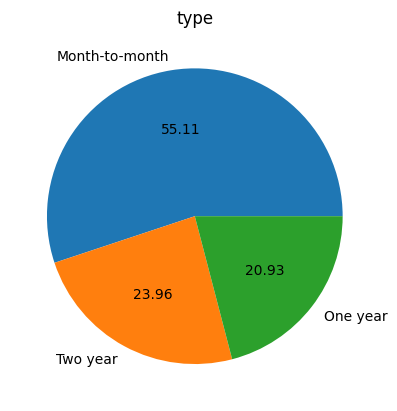

paperless_billing 

Yes    4168
No     2864
Name: paperless_billing, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


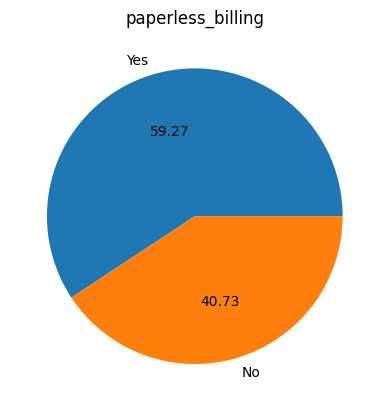

payment_method 

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: payment_method, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


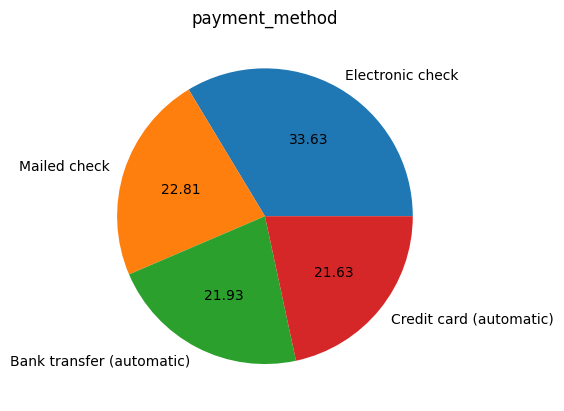

gender 

Male      3549
Female    3483
Name: gender, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


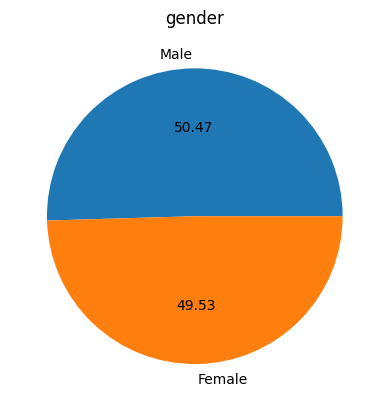

partner 

No     3639
Yes    3393
Name: partner, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


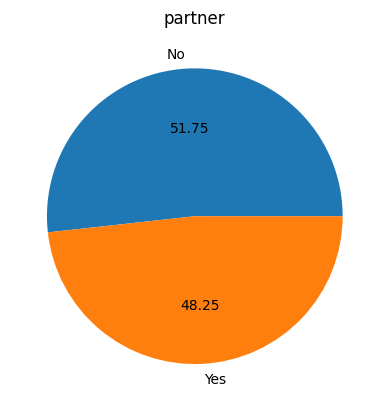

dependents 

No     4933
Yes    2099
Name: dependents, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


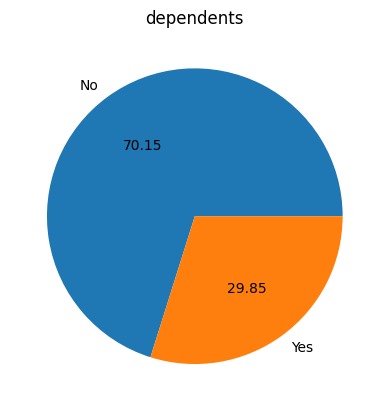

internet_service 

Fiber optic    3096
DSL            2416
Name: internet_service, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


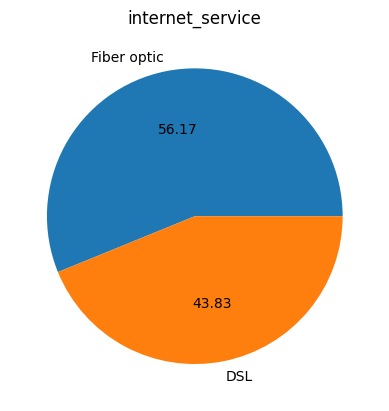

online_security 

No     3497
Yes    2015
Name: online_security, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


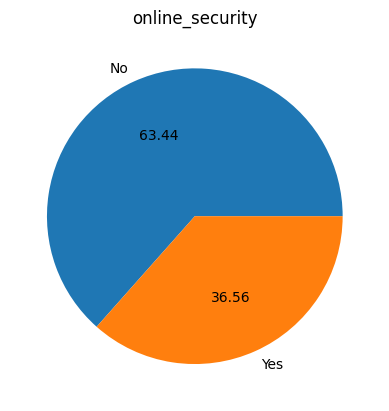

online_backup 

No     3087
Yes    2425
Name: online_backup, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


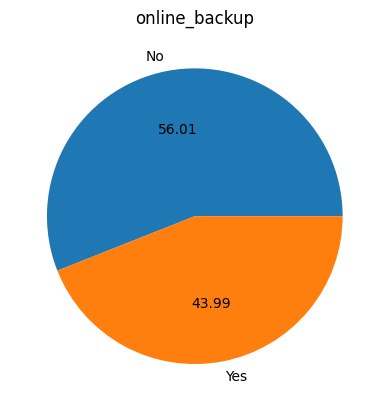

device_protection 

No     3094
Yes    2418
Name: device_protection, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


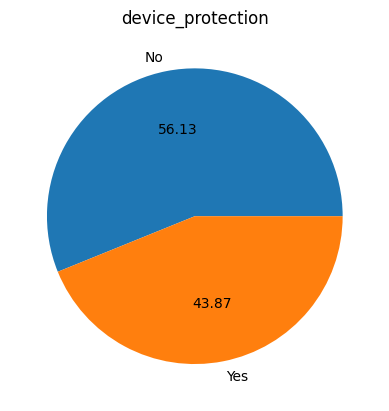

tech_support 

No     3472
Yes    2040
Name: tech_support, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


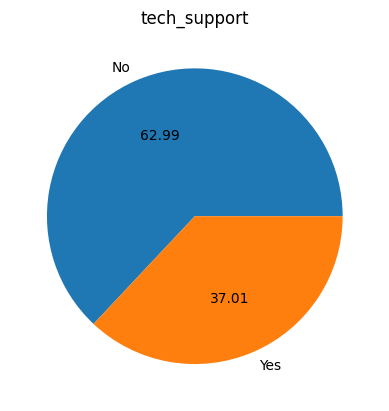

streaming_tv 

No     2809
Yes    2703
Name: streaming_tv, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


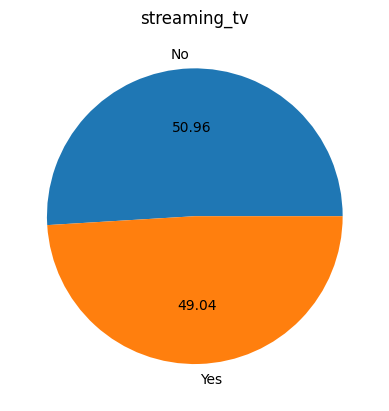

streaming_movies 

No     2781
Yes    2731
Name: streaming_movies, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


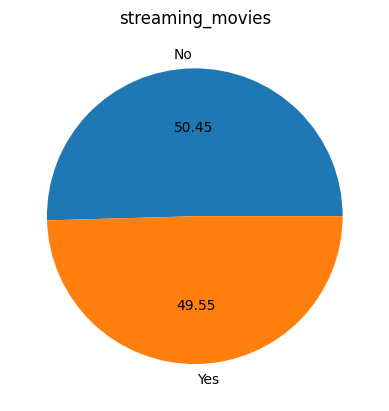

multiple_lines 

No     3385
Yes    2967
Name: multiple_lines, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


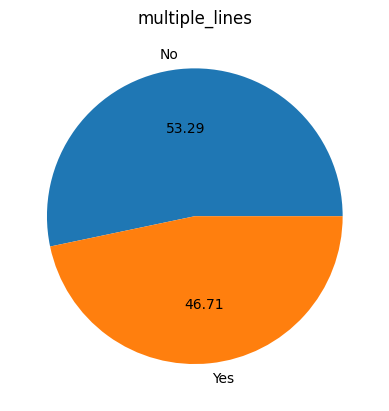

senior_citizen 

0    5890
1    1142
Name: senior_citizen, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


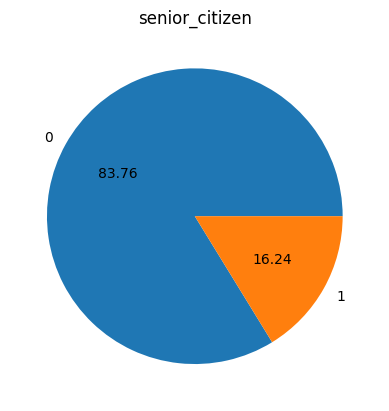

In [28]:
# exploration of numerical features
for col in cat_col_names:
    print(col, '\n')
    print(data[col].value_counts(),'\n')
    print(data[col].value_counts().plot(kind='pie', title=col, ylabel='', autopct='%.2f'))
    plt.show()

In [29]:
# replace missing values in the columns internet_service, online_security, online_backup, 
# device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines with 'unknown'
data = data.fillna('unknown')

internet_service 

Fiber optic    3096
DSL            2416
unknown        1520
Name: internet_service, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


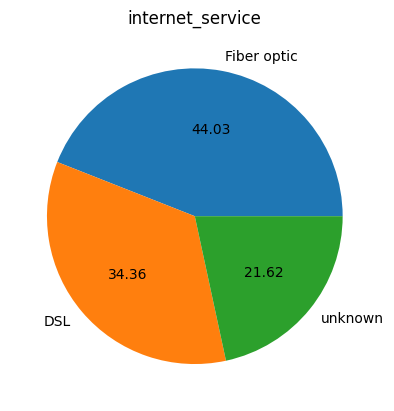

online_security 

No         3497
Yes        2015
unknown    1520
Name: online_security, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


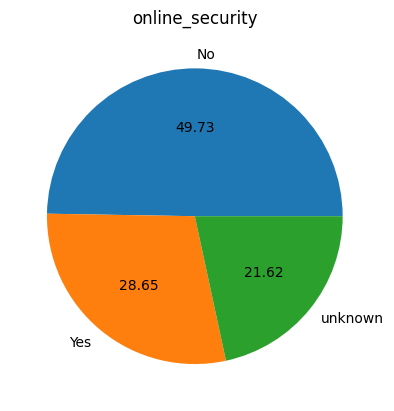

online_backup 

No         3087
Yes        2425
unknown    1520
Name: online_backup, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


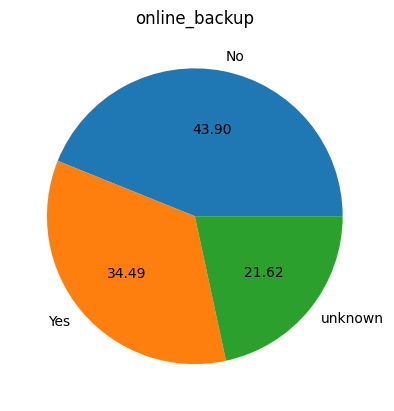

device_protection 

No         3094
Yes        2418
unknown    1520
Name: device_protection, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


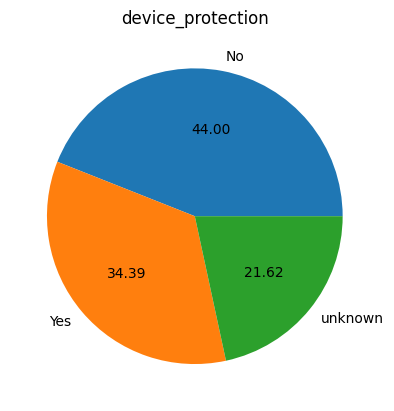

tech_support 

No         3472
Yes        2040
unknown    1520
Name: tech_support, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


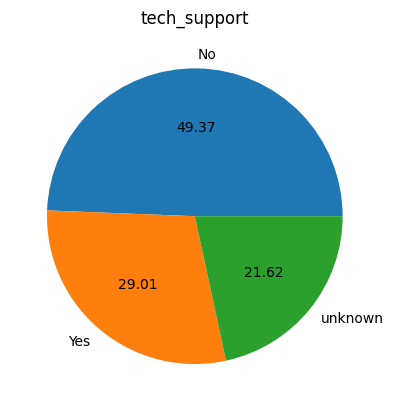

streaming_tv 

No         2809
Yes        2703
unknown    1520
Name: streaming_tv, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


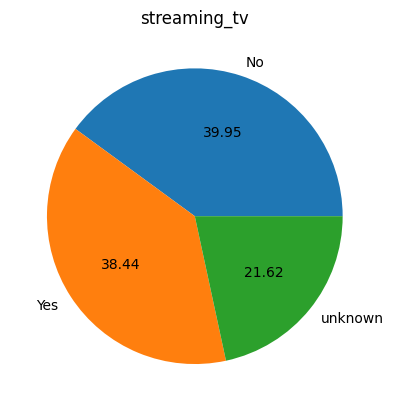

streaming_movies 

No         2781
Yes        2731
unknown    1520
Name: streaming_movies, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


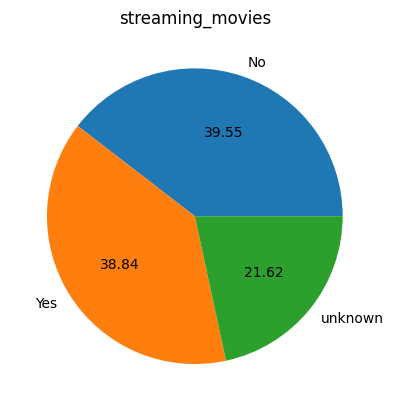

multiple_lines 

No         3385
Yes        2967
unknown     680
Name: multiple_lines, dtype: int64 

AxesSubplot(0.22375,0.11;0.5775x0.77)


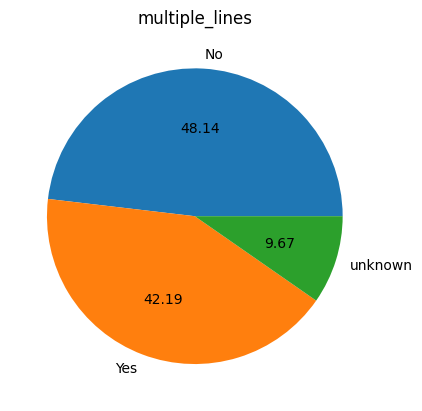

In [30]:
# after replacing missing values, re-explore the numerical features
for col in ['internet_service', 'online_security', 'online_backup', 'device_protection', \
            'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
    print(col, '\n')
    print(data[col].value_counts(),'\n')
    print(data[col].value_counts().plot(kind='pie', title=col, ylabel='', autopct='%.2f'))
    plt.show()

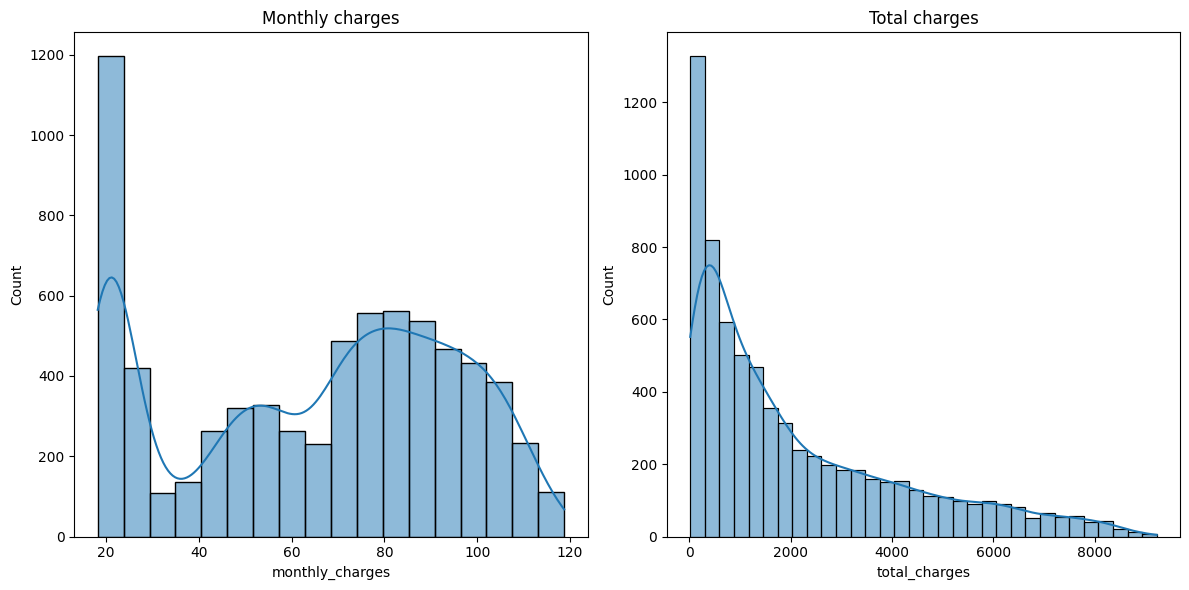

In [31]:
# explore continuous numerical features 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sb.histplot(data=data['monthly_charges'], kde=True, ax=axes[0])
axes[0].set_title('Monthly charges')
sb.histplot(data=data['total_charges'], kde=True, ax=axes[1])
axes[1].set_title('Total charges')

plt.tight_layout()
plt.show()

In [32]:
data.pivot_table(index=('internet_service'), values=('monthly_charges'), aggfunc=('median', 'count')).head()

,count,median
internet_service,,
DSL,2416,56.150
Fiber optic,3096,91.675
unknown,1520,20.150


In [33]:
data.pivot_table(index=('online_backup'), values=('monthly_charges'), aggfunc=('median', 'count')).head()

,count,median
online_backup,,
No,3087,74.75
Yes,2425,85.85
unknown,1520,20.15


In [34]:
data.pivot_table(index=('online_security'), values=('monthly_charges'), aggfunc=('median', 'count')).head()

,count,median
online_security,,
No,3497,79.30
Yes,2015,79.85
unknown,1520,20.15


In [35]:
data.pivot_table(index=('device_protection'), values=('monthly_charges'), aggfunc=('median', 'count')).head()

,count,median
device_protection,,
No,3094,74.000
Yes,2418,88.575
unknown,1520,20.150


In [36]:
data.pivot_table(index=('tech_support'), values=('monthly_charges'), aggfunc=('median', 'count')).head()

,count,median
tech_support,,
No,3472,78.050
Yes,2040,81.725
unknown,1520,20.150


In [37]:
data.pivot_table(index=('streaming_tv'), values=('monthly_charges'), aggfunc=('median', 'count')).head()

,count,median
streaming_tv,,
No,2809,69.60
Yes,2703,93.25
unknown,1520,20.15


In [38]:
data.pivot_table(index=('streaming_movies'), values=('monthly_charges'), aggfunc=('median', 'count')).head()

,count,median
streaming_movies,,
No,2781,69.65
Yes,2731,93.20
unknown,1520,20.15


In [39]:
data.pivot_table(index=('multiple_lines'), values=('monthly_charges'), aggfunc=('median', 'count')).head()

,count,median
multiple_lines,,
No,3385,56.05
Yes,2967,88.05
unknown,680,40.55


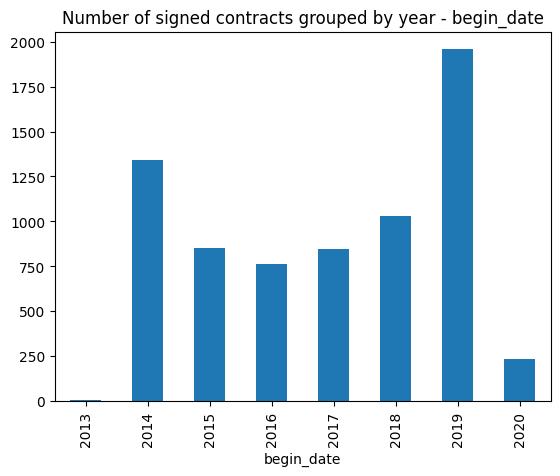

In [40]:
# examine the contract start date
# convert the 'begin_date' to datetime format
data['begin_date'] = pd.to_datetime(data['begin_date'])
data['begin_date'].groupby(data['begin_date'].dt.year).count() \
                  .plot(kind="bar", title='Number of signed contracts grouped by year - begin_date');

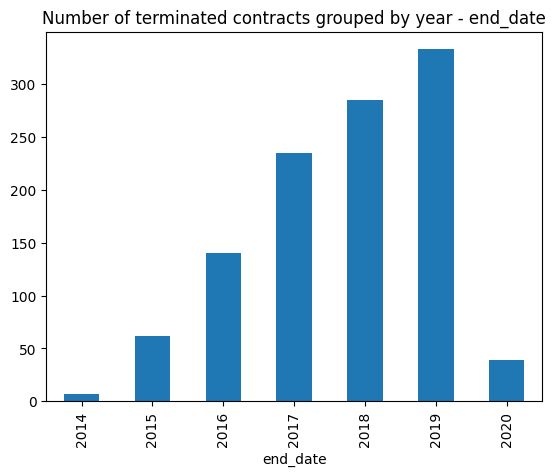

In [41]:
# examine the termination date of contracts
pd.to_datetime(data[data['end_date'] != 'No']['end_date']). \
   groupby([pd.to_datetime(data[data['end_date'] != 'No']['end_date']).dt.year]).count() \
   .plot(kind="bar", title='Number of terminated contracts grouped by year - end_date');

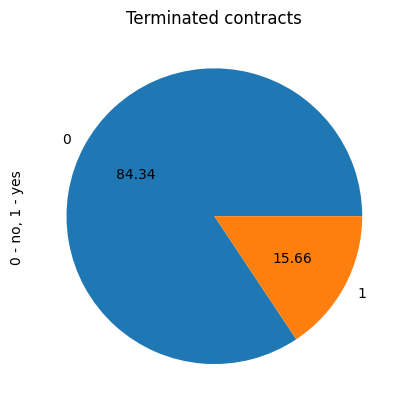

In [42]:
# create a new column "Contract Terminated", where 0 = no and 1 = yes, this will be the target variable
data['terminated'] = data['end_date'].apply(lambda x: 0 if 'No' in x else 1)
data['terminated'].value_counts() \
                  .plot(kind='pie', title='Terminated contracts', ylabel='0 - no, 1 - yes', autopct='%.2f');

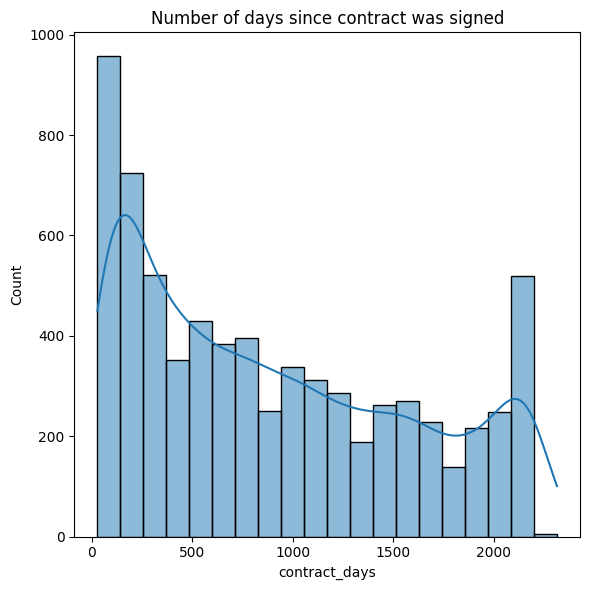

In [43]:
# create a new feature "number of days since contract was signed"
# for customers who did not terminate the contract, use the export date '2020-02-01' as the end-date

def get_days(begin, end):
    return (pd.to_datetime(end) - pd.to_datetime(begin)).days

data['contract_days'] = data.apply(lambda x: get_days(x.begin_date, '2020-02-01') if 'No' in x.end_date \
                                   else get_days(x.begin_date, x.end_date), axis=1)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sb.histplot(data=data['contract_days'], kde=True, ax=axes, bins=20)
axes.set_title('Number of days since contract was signed')

plt.tight_layout()
plt.show()

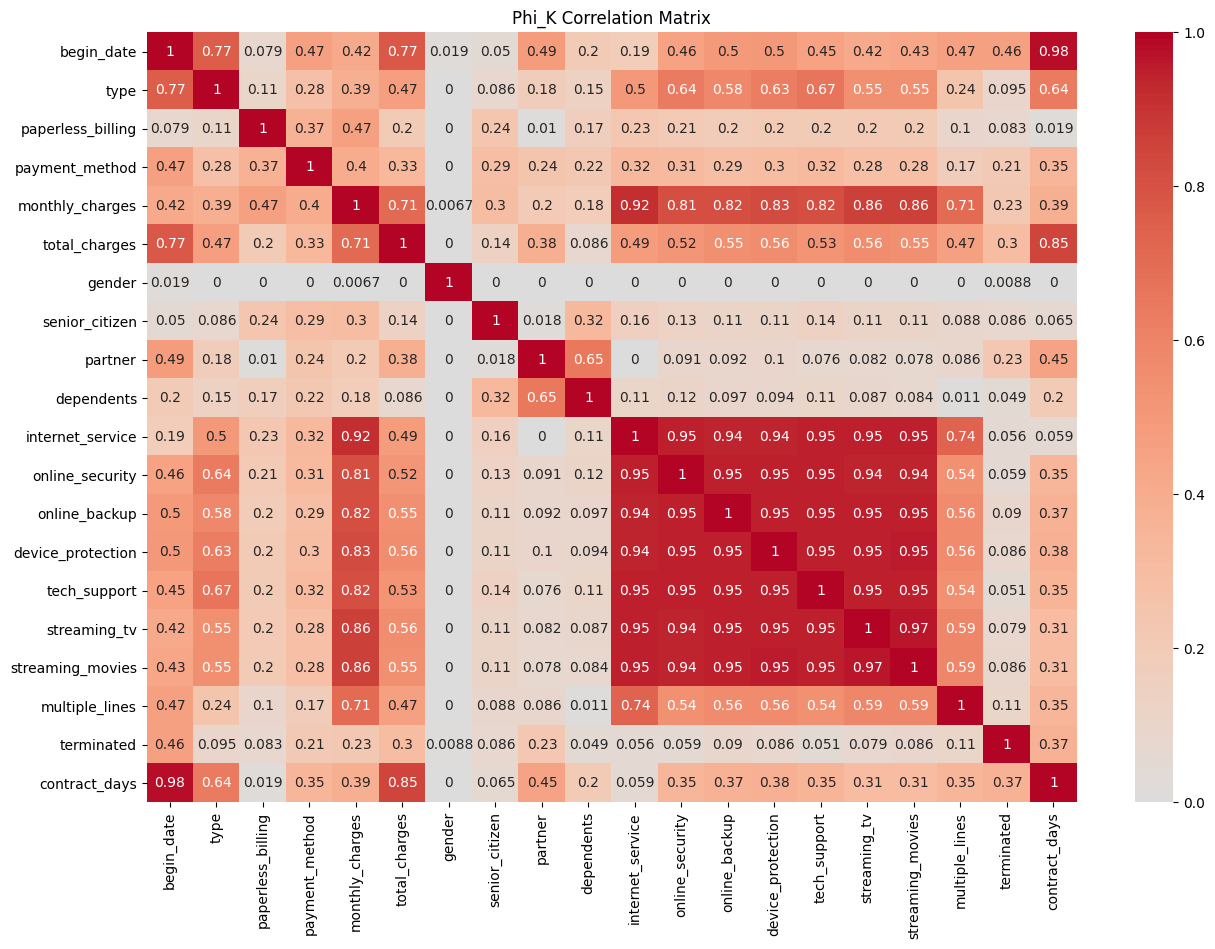

In [44]:
# correlation matrix using phik
interval_cols = ['monthly_charges', 'total_charges', 'contract_days']

corr_matrix = data.drop(['customer_id', 'end_date'], axis=1).phik_matrix(interval_cols=interval_cols)


plt.figure(figsize=(15, 10))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Phi_K Correlation Matrix')
plt.show()

In [45]:
data[['internet_service', 'streaming_tv']].value_counts()

internet_service  streaming_tv
Fiber optic       Yes             1750
unknown           unknown         1520
DSL               No              1463
Fiber optic       No              1346
DSL               Yes              953
dtype: int64

# Results

- The following features were explored:
    - begin_date — contract start date, ranging from 2013 to 2020, with the peak in 2019
    - end_date — contract end date, 84% of contracts are active, while the remaining 16% are terminated, with the peak of terminations in 2019
    - type — payment type: annually 24%, every two years 21%, or monthly 55%
    - paperless_billing — electronic billing: yes 59%, no 41%
    - payment_method — payment method: Electronic check 33%, Mailed check 23%, Bank transfer (automatic) 22%, Credit card (automatic) 22%
    - monthly_charges — monthly expenses range from 18 to 118 units, with the histogram showing 3 peaks that seem to correspond with the type of internet service: DSL median is 56.150, Fiber optic median is 91.675, and for those with an unknown connection type, the median is 20.150
    - total_charges — total charges range from 19 to 9221 units, with a histogram showing fewer customers with higher total charges
    - gender — gender: male/female ratio is approximately 50/50%
    - senior-citizen — whether the customer is a senior citizen: no (0) 84%, yes (1) 16%
    - partner — whether the customer has a partner: no 52%, yes 48%
    - dependents — whether the customer has dependents: no 70%, yes 30%
    - internet_service — type of internet connection: DSL 34%, Fiber optic 44%, unknown 22%
    - online_security — online security: no 50%, yes 29%, unknown 22%
    - online_backup — cloud backup: no 44%, yes 34%, unknown 22%
    - device_protection — antivirus: no 44%, yes 34%, unknown 22%
    - tech_support — dedicated tech support: no 49%, yes 29%, unknown 22%
    - streaming_tv — streaming TV: no 40%, yes 38%, unknown 22%
    - streaming_movies — movie catalog: no 39%, yes 39%, unknown 22%
    - multiple_lines — multiple phone lines: no 48%, yes 42%, unknown 10%

- Missing values were filled with "unknown" because strategies like "most frequent" or "mean/median" do not work in this case due to categorical features with nearly equal percentage distributions. What is interesting about this group of customers is that they have significantly lower monthly payments. It would be worth discussing with the client what these customers could be, perhaps a special promotion or a unique service package. It is possible that they do not have any additional services, but this cannot be confirmed.

- New features were added:
    - Contract duration (in days) — the histogram shows two small peaks: very short contracts and very long contracts
    - Target feature "contract terminated" (1 — terminated 16%, 0 — not terminated 84%)

- A correlation analysis was conducted:
    - begin_date has a high correlation with contract_days, which makes sense. begin_date will not be used for model training.
    - begin_date also correlates with total_charges and payment type
    - monthly_charges have a strong relationship with the connection type and other internet services
    - monthly_charges also correlate with total charges, which is logical
    - furthermore, internet services are correlated with each other, possibly because customers often purchase them as a package. The highest correlation coefficient (0.97) is between streaming_tv and streaming_movies
    - multiple_lines correlates with the internet service type

## Data Preparation <a id='section5'></a>

In [46]:
# split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(data.drop(['customer_id', 'end_date', \
                                                               'begin_date', 'terminated'], axis=1), 
                                                                data['terminated'], 
                                                                test_size=TEST_SIZE, 
                                                                stratify=data['terminated'],
                                                                random_state=RANDOM_STATE)

print('X_train:', X_train.shape, 
      'X_test:', X_test.shape, 
      'y_train:', y_train.shape,
      'y_test:', y_test.shape)   

X_train: (5274, 18) X_test: (1758, 18) y_train: (5274,) y_test: (1758,)


In [47]:
# columns with categorical and numerical features

cat_col_names = data.drop(['customer_id', 'begin_date', 'end_date'], axis=1).select_dtypes(exclude='number') \
                    .columns.tolist() + ['senior_citizen']
num_columns = data.drop(['senior_citizen', 'terminated', 'begin_date'], axis=1).select_dtypes(include='number') \
                  .columns.tolist()
cat_col_names, num_columns

(['type',
  'paperless_billing',
  'payment_method',
  'gender',
  'partner',
  'dependents',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies',
  'multiple_lines',
  'senior_citizen'],
 ['monthly_charges', 'total_charges', 'contract_days'])

In [48]:
ord_categories = []
for cat in cat_col_names:
    ord_categories.append(data[cat].unique().tolist())
ord_categories

[['Month-to-month', 'One year', 'Two year'],
 ['Yes', 'No'],
 ['Electronic check',
  'Mailed check',
  'Bank transfer (automatic)',
  'Credit card (automatic)'],
 ['Female', 'Male'],
 ['Yes', 'No'],
 ['No', 'Yes'],
 ['DSL', 'Fiber optic', 'unknown'],
 ['No', 'Yes', 'unknown'],
 ['Yes', 'No', 'unknown'],
 ['No', 'Yes', 'unknown'],
 ['No', 'Yes', 'unknown'],
 ['No', 'Yes', 'unknown'],
 ['No', 'Yes', 'unknown'],
 ['unknown', 'No', 'Yes'],
 [0, 1]]

In [49]:
# data preprocessing for the "Decision Tree" model
# pipeline for feature preprocessing from the list cat_col_names - Ordinal encoding + SimpleImputer

ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(
                categories=ord_categories, 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# pipeline for data preprocessing
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, cat_col_names)
    ], 
    remainder='passthrough'
)

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(categories=[['Month-to-month',
                                                                              'One '
                                                                              'year',
                                                                              'Two '
                                                                              'year'],
                                                                             ['Yes',
                                                                              'No'],
                                                                             ['Electronic '
                                                                              'check',
                                                                              'Mailed '
                                                                              'check',
                                                                              'Bank '
                                                                              'transfer '
                                                                              '(automatic)',
                                                                              'Credit '
                                                                              'card '
                                                                              '(automatic)'],
                                                                             ['Female',
                                                                              'Male'],
                                                                             ['Yes',
                                                                              'No'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['DSL',
                                                                              'Fiber '
                                                                              'optic',
                                                                              'unknown'],
                                                                             ['No',
                                                                              'Y...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['type', 'paperless_billing', 'payment_method',
                                  'gender', 'partner', 'dependents',
                                  'internet_service', 'online_security',
                                  'online_backup', 'device_protection',
                                  'tech_support', 'streaming_tv',
                                  'streaming_movies', 'multiple_lines',
                                  'senior_citizen'])])

# Results

- The data was split into training and test sets with a 3:1 ratio — X_train: (5274, 18), X_test: (1758, 18), y_train: (5274,), y_test: (1758,)
- Columns with categorical and numerical features were selected
- A pipeline was created for data preprocessing for the "Decision Tree" model

## Training Machine Learning Models <a id='section6'></a>

In [50]:
# first model - Decision Tree

selector = SelectKBest(f_classif)

# final pipeline: preprocessing and model
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('feature_selection', selector),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # dictionary for the DecisionTreeClassifier() model
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 11),
        'models__max_features': range(4, 11),
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(2, 11),
        'feature_selection__k': range(9, 19)
    }
]

In [51]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train, y_train)
k_model1 = rs.best_estimator_

print('Best model and its parameters is\n\n', rs.best_estimator_)
print ('\nThe metric of the best model using cross-validation is', round(rs.best_score_, 3))

Best model and its parameters is

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['Month-to-month',
                                                                                               'One '
                                                                                               'year',
                                                                                               'Two '
                                                                                               'year'],
                                                                                              ['Yes',
                                                                                               'No'],
             

In [52]:
# train the second model - Gradient Boosting using CatBoost

model1_pipeline = Pipeline([
    ('model', CatBoostClassifier(random_state=RANDOM_STATE))
])

param_grid1 = [
    {
        'model__iterations': [30, 90, 150, 200],
        'model__depth': [6, 7, 8, 9],
        'model__verbose': [10],
        'model__learning_rate': [0.44],
        'model__cat_features': [cat_col_names]
        
    }
]

grid1 = GridSearchCV(
    model1_pipeline, 
    param_grid=param_grid1, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-1
)

grid1.fit(X_train, y_train)


print('Best model and its parameters is\n\n', grid1.best_estimator_, grid1.best_params_)
print ('The metric of the best model using cross-validation is', round(grid1.best_score_, 3))

0:	learn: 0.4598928	total: 76.4ms	remaining: 15.2s
10:	learn: 0.3108111	total: 159ms	remaining: 2.73s
20:	learn: 0.2863145	total: 249ms	remaining: 2.12s
30:	learn: 0.2646736	total: 377ms	remaining: 2.05s
40:	learn: 0.2433543	total: 485ms	remaining: 1.88s
50:	learn: 0.2184918	total: 600ms	remaining: 1.75s
60:	learn: 0.1960997	total: 715ms	remaining: 1.63s
70:	learn: 0.1801525	total: 832ms	remaining: 1.51s
80:	learn: 0.1651822	total: 939ms	remaining: 1.38s
90:	learn: 0.1526941	total: 1.08s	remaining: 1.29s
100:	learn: 0.1379441	total: 1.18s	remaining: 1.16s
110:	learn: 0.1292715	total: 1.3s	remaining: 1.04s
120:	learn: 0.1204470	total: 1.41s	remaining: 923ms
130:	learn: 0.1130662	total: 1.53s	remaining: 809ms
140:	learn: 0.1060842	total: 1.65s	remaining: 689ms
150:	learn: 0.1022131	total: 1.77s	remaining: 574ms
160:	learn: 0.0950197	total: 1.88s	remaining: 456ms
170:	learn: 0.0892211	total: 2.01s	remaining: 341ms
180:	learn: 0.0828620	total: 2.13s	remaining: 224ms
190:	learn: 0.0790800	t

**Results**

- Two models with different hyperparameters were trained — Decision Tree and Gradient Boosting using CatBoost
- The metric of the best model using cross-validation for the Decision Tree: 0.766
- The metric of the best model using cross-validation for Gradient Boosting: 0.864

## Model Selection <a id='section7'></a>

The best model is the **Gradient Boosting model using CatBoost**. The hyperparameters of the best model are: {'model__depth': 6, 'model__iterations': 200, 'model__learning_rate': 0.4, 'model__verbose': 10}
The metric of the best model using cross-validation: **0.864**

In [53]:
best_model = grid1.best_estimator_

In [54]:
y_pred = best_model.predict(X_test)
preds_test = best_model.predict_proba(X_test)

f'ROC_AUC metric on the test set is {round(roc_auc_score(y_test, preds_test[:,1]), 3)}'

'ROC_AUC metric on the test set is 0.905'

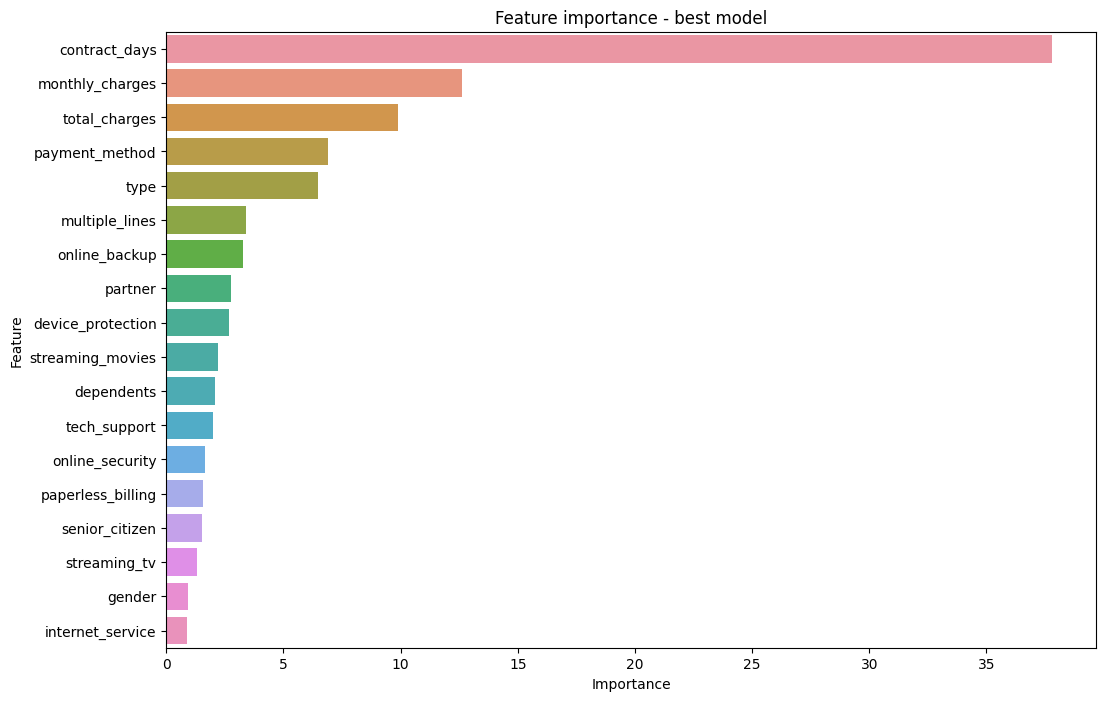

In [55]:
# feature importance
feature_importances = pd.DataFrame(
    {
        'Feature': data.drop(['customer_id', 'end_date', 'begin_date', 'terminated'], axis=1).columns,
        'Importance': best_model.steps[0][1].feature_importances_
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
ax = sb.barplot(x='Importance', y='Feature', data=feature_importances) \
       .set(title='Feature importance - best model')

  0%|          | 0/100 [00:00<?, ?it/s]

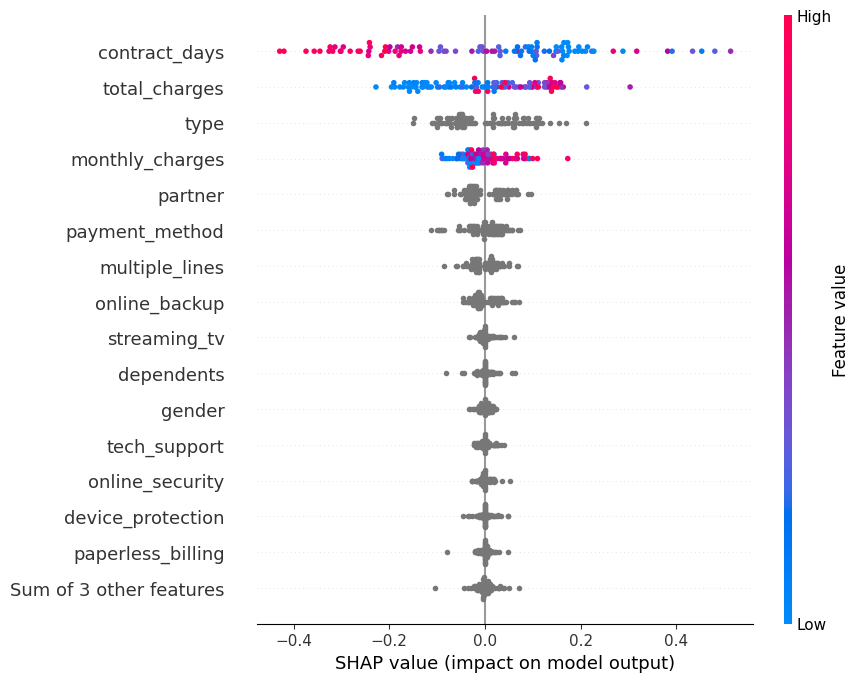

In [56]:
# plot the feature importance using the SHAP method

explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_test, 100), keep_index=True) 
shap_values = explainer(shap.sample(X_test, 100))
shap.plots.beeswarm(shap_values[:,:,1], max_display=16)


In [57]:
data.pivot_table(index=('type'), values=('terminated'), aggfunc=('mean', 'count')).head()

,count,mean
type,,
Month-to-month,3875.0,0.105032
One year,1472.0,0.212636
Two year,1685.0,0.226113


In [58]:
data.pivot_table(index=('payment_method'), values=('terminated'), aggfunc=('mean', 'count')).head()

,count,mean
payment_method,,
Bank transfer (automatic),1542.0,0.205577
Credit card (automatic),1521.0,0.208416
Electronic check,2365.0,0.147992
Mailed check,1604.0,0.072943


In [59]:
data.pivot_table(index=('multiple_lines'), values=('terminated'), aggfunc=('mean', 'count')).head()

,count,mean
multiple_lines,,
No,3385.0,0.094535
Yes,2967.0,0.228514
unknown,680.0,0.151471


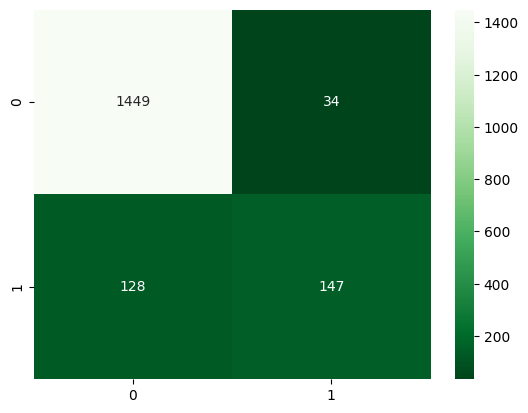

In [60]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Greens_r');

**Results**

- The best model was selected — the Gradient Boosting model using CatBoost. The hyperparameters of the best model are: {'model__depth': 6, 'model__iterations': 200, 'model__learning_rate': 0.4, 'model__verbose': 10}. The metric of the best model using cross-validation: 0.864
- Predictions were made on the test set using the best model, and the ROC_AUC metric was calculated: 0.905
- The importance of features was analyzed. Using the Shapley method, the influence of numerical features on the target was observed. Given the risk of contract termination, attention should be given to clients who:
    - Recently signed a contract
    - Have higher total and monthly charges
    - Have a payment type of 1 or 2 years
    - Use automatic payment methods
- The most significant features: contract_days, total_charges, monthly_charges, type, payment_method
- The least significant features: gender, senior_citizen, internet_service, paperless_billing, tech_support
- The confusion matrix shows that the number of correct predictions for "0" is 1449, the number of correct predictions for "1" is 147, the number of false positives is 34, and the number of false negatives is 128.


## Summary and Recommendations for the Client <a id='section8'></a>

1. The data was loaded into 4 tables. The contract table and the customer table contain 7043 rows, the internet services table contains 5517 rows, and the phone services table contains 6361 rows.


2. Preliminary data analysis was conducted. The following points were noted:
   - The "end_date" column contains mostly "No" values, with the rest as dates. This feature will be the target variable, meaning it needs to be transformed into "Canceled" and "Not Canceled." It cannot be used as an input feature.
   - It was observed that the ratio of canceled customers to retained customers is approximately 1:6.
   - The internet and phone services tables have fewer rows than the contract and customer tables. This means that after merging, there will be missing values in these columns, and they will need to be handled.


3. The data from the four tables was merged into one. There are 20 columns and 7032 rows.

4. The following features were explored:
   - begin_date — the contract start date — ranging from 2013 to 2020, with the peak in 2019.
   - end_date — the contract end date — 84% of contracts are active, and the remaining 16% are canceled, with the peak cancellation in 2019.
   - type — payment type: annually 24%, biennially 21%, or monthly 55%.
   - paperless_billing — electronic billing: Yes 59%, No 41%.
   - payment_method — payment method: Electronic check 33%, Mailed check 23%, Bank transfer (automatic) 22%, Credit card (automatic) 22%.
   - monthly_charges — monthly charges range from 18 to 118 USD; the histogram shows 3 peaks that appear to correlate with the internet service type: DSL median 56.150, Fiber optic median 91.675, and for those with an unknown service type (unknown) median 20.150.
   - total_charges — total charges range from 19 to 9221 USD; the histogram shows that higher total charges are associated with fewer clients.
   - gender — gender: male/female is approximately 50/50%.
   - senior-citizen — whether the customer is a senior citizen: No (0) 84%, Yes (1) 16%.
   - partner — whether the customer has a partner: No 52%, Yes 48%.
   - dependents — whether the customer has dependents: No 70%, Yes 30%.
   - internet_service — internet service type: DSL 34%, Fiber optic 44%, unknown 22%.
   - online_security — online security: No 50%, Yes 29%, unknown 22%.
   - online_backup — online backup: No 44%, Yes 34%, unknown 22%.
   - device_protection — device protection: No 44%, Yes 34%, unknown 22%.
   - tech_support — tech support: No 49%, Yes 29%, unknown 22%.
   - streaming_tv — streaming TV: No 40%, Yes 38%, unknown 22%.
   - streaming_movies — streaming movies: No 39%, Yes 39%, unknown 22%.
   - multiple_lines — multiple phone lines: No 48%, Yes 42%, unknown 10%.

   - Missing values were filled with "unknown" since strategies like "most frequent" or "mean/median" do not work well for categorical features with closely matched percentage distributions. Interestingly, this group of customers has significantly lower monthly payments. It would be useful to ask the client more about these customers, as they might be on a special offer or package. Perhaps they have no additional services, but this cannot be confirmed.

New features were created:
   - Contract days — the histogram shows two small peaks: very short contracts and very long ones.
   - Target feature — contract canceled (1 - canceled, 16%, 0 - not canceled, 84%).
    

A correlation analysis:
   - begin_date shows a strong correlation with contract_days, which makes sense. begin_date will not be used for model training.
   - begin_date also correlates with total_charges and payment type.
   - monthly_charges has a strong relationship with the internet service type and other internet services.
   - monthly_charges also correlates with total_charges, which is logical.
   - Furthermore, internet services correlate with each other, suggesting that customers tend to purchase them in bundles. The highest correlation coefficient (0.97) is between streaming_tv and streaming_movies.
   - multiple_lines correlates with the internet_service type.


5. The data was split into training and test sets in a 3:1 ratio — X_train: (5274, 18), X_test: (1758, 18), y_train: (5274,), y_test: (1758,).


6. Two models with different hyperparameters were trained: Decision Tree and Gradient Boosting using CatBoost:
   - the metric of the best model using cross-validation for Decision Tree model: 0.766.
   - the metric of the best model using cross-validation for Gradient Boosting model: 0.864.
   - The following features were used for training the models:
     - Categorical features: type, paperless_billing, payment_method, gender, partner, dependents, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines, senior_citizen.
     - Numerical features: monthly_charges, total_charges, contract_days.


7. The best model is the Gradient Boosting model using CatBoost. The hyperparameters of the best model are: {'model__depth': 6, 'model__iterations': 200, 'model__learning_rate': 0.4, 'model__verbose': 10}. The metric of the best model using cross-validation: 0.864.
- Predictions were made on the test set using the best model, and the ROC_AUC metric was calculated: 0.905.
   
8. Given the risk of contract termination, attention should be paid to customers who: 
- Recently signed a contract
- Have higher total and monthly charges
- Have a payment type of 1 or 2 years
- Use automatic payment methods   
 
 
* The most significant features: contract_days, total_charges, monthly_charges, type, payment_method.    
* The least significant features: gender, senior_citizen, internet_service, paperless_billing, tech_support.    